# Importing Library

In [ ]:
# importing library

import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from abc import abstractmethod
import keras.layers as Kl
import keras.models as Km
from pathlib import Path
import os
import csv
import random

# Main Board

This class has game initialization , main gameloop and also main gameloop with learning method.

In [ ]:

class TicTacToe():

    def __init__(self, player1, player2, exp1=1, exp2=1):
        self.state = '123456789'

        player1 = globals()[player1]
        self.player1 = player1(tag='X', exploration_factor=exp1)
        player2 = globals()[player2]
        self.player2 = player2(tag='O', exploration_factor=exp2)

        self.winner = None
        self.turn = 'X'
        self.player_turn = self.player1

        self.Xcount = 0
        self.Ocount = 0
        self.Tcount = 0
        self.all_count = 0

    def play_game(self):

        if isinstance(self.player1, QAgent):
            self.player1.exp_factor = 1
        if isinstance(self.player2, QAgent):
            self.player2.exp_factor = 1

        while self.winner is None:

            if type(self.player_turn) == Player:
                print(self.turn)
                self.print_game()

            self.state = self.play_move()
            self.game_winner()

            if self.winner is not None:
                break

        self.print_game()

    def play_to_learn(self, episodes):

        for i in range(episodes+1):
            # episodes

            while self.winner is None:
                self.state = self.play_move(learn=True)
                self.game_winner()

                if self.winner is not None:
                    break

                self.state = self.play_move(learn=True)
                self.game_winner()

            # learning last state
            self.state = self.play_move(learn=True)
            self.state = self.play_move(learn=True)
            # learning winning state
            self.state = self.play_move(learn=True)
            self.state = self.play_move(learn=True)

            if (i+1)% 100 == 0:
                self.print_bar()
                print('#################')
                self.player1.print_value = True
            else:
                self.player1.print_value = False

            

            self.all_count = i
            self.init_game()

        self.print_summary()
        self.player1.save_values()
        self.player2.save_values()

    def play_move(self, learn=False):

        if self.turn == 'X':
            if learn is True:
                new_state = self.player1.make_move_and_learn(self.state, self.winner)
            else:
                new_state = self.player1.make_move(self.state, self.winner)
            self.turn = 'O'
            self.player_turn = self.player2
        else:
            if learn is True:
                new_state = self.player2.make_move_and_learn(self.state, self.winner)
            else:
                new_state = self.player2.make_move(self.state, self.winner)
            self.turn = 'X'
            self.player_turn = self.player1
        return new_state

    def print_game(self):

        s = list(self.state)

        print('    {} | {} | {}'.format(s[0], s[1], s[2]))
        print('  --------------')
        print('    {} | {} | {}'.format(s[3], s[4], s[5]))
        print('  --------------')
        print('    {} | {} | {}'.format(s[6], s[7], s[8]))
        print('  --------------')
        print('  --------------')

    def game_winner(self):

        winner = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]]
        for line in winner:
            s = self.state[line[0]] + self.state[line[1]] + self.state[line[2]]
            if s == 'XXX':
                self.winner = 'X'
                break
            elif s == 'OOO':
                self.winner = 'O'
                break
            elif not any(s.isnumeric() for s in list(self.state)):
                self.winner = 'No winner'
        self.check_winner()
        return self.winner

    def check_winner(self):

        if self.winner == 'X':
            self.Xcount += 1
            

        elif self.winner == 'O':
            self.Ocount += 1
            

        elif self.winner == 'No winner':
            self.Tcount += 1
            

    def init_game(self):
        self.state = '123456789'
        self.winner = None
        self.turn = 'X'
        self.player_turn = self.player1

    def print_bar(self):

        plt.close()
        fig = plt.figure()
        ax1 = fig.add_subplot(2, 1, 1)
        ax2 = fig.add_subplot(2, 1, 2)

        x = ['X', 'Tie', 'O', 'Sum']
        a = self.Xcount
        b = self.Tcount
        c = self.Ocount
        d = self.all_count

        aprec = 100*a / (a + b + c + 1)
        bprec = 100*b / (a + b + c + 1)
        cprec = 100*c / (a + b + c + 1)

        ax1.clear()
        ax2.clear()
        bar1 = ax1.bar(x, [a, b, c, d])
        bar1[0].set_color('r')
        bar1[1].set_color('b')
        ax1.set_ylim((0, d + 100))
        plt.draw()

        bar2 = ax2.bar(x[0:3], [aprec, bprec, cprec])
        bar2[0].set_color('r')
        bar2[1].set_color('b')
        ax2.set_ylim((0, 100))

        for rect in bar2:
            height = rect.get_height()
            ax2.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
                    '%d' % int(height),
                    ha='center', va='bottom')

        plt.draw()

        plt.pause(0.05)

    def print_summary(self):
        a = ['X',   self.Xcount, 100 * self.Xcount / (self.Xcount + self.Ocount + self.Tcount)]
        b = ['O',   self.Ocount, 100 * self.Ocount / (self.Xcount + self.Ocount + self.Tcount)]
        c = ['Tie', self.Tcount, 100 * self.Tcount / (self.Xcount + self.Ocount + self.Tcount)]
        tab = tabulate([a, b, c], headers=['Player', 'num of wins', 'prec'])
        print(tab)

# Player class for playing interactively.

In [ ]:
class Player():

    def __init__(self, tag, exploration_factor=1):
        self.tag = tag
        self.print_value = False
        self.exp_factor = exploration_factor

    def make_move(self, state, winner):
        idx = int(input('Choose move number: '))
        s = state[:idx-1] + self.tag + state[idx:]
        return s

# Agent

In [ ]:
class Agent(Player):

    def __init__(self, tag, exploration_factor=1):
        super().__init__(tag, exploration_factor)
        self.epsilon = 0.1
        self.alpha = 0.5
        self.prev_state = '123456789'
        self.state = None
        self.print_value = False

        if self.tag == 'X':
            self.op_tag = 'O'
        else:
            self.op_tag = 'X'

    @abstractmethod
    def calc_value(self, state):
        pass

    @abstractmethod
    def learn_state(self, state, winner):
        pass

    def make_move(self, state, winner):

        self.state = state

        if winner is not None:
            new_state = state
            return new_state

        p = random.uniform(0, 1)
        if p < self.exp_factor:
            new_state = self.make_optimal_move(state)
        else:
            moves = [s for s, v in enumerate(state) if v.isnumeric()]
            idx = random.choice(moves)
            new_state = state[:idx] + self.tag + state[idx + 1:]

        return new_state

    def make_move_and_learn(self, state, winner):

        self.learn_state(state, winner)

        return self.make_move(state, winner)

    def make_optimal_move(self, state):
        moves = [s for s, v in enumerate(state) if v.isnumeric()]

        if len(moves) == 1:
            temp_state = state[:moves[0]] + self.tag + state[moves[0] + 1:]
            new_state = temp_state
            return new_state

        temp_state_list = []
        v = -float('Inf')

        for idx in moves:

            v_temp = []
            temp_state = state[:idx] + self.tag + state[idx + 1:]

            moves_op = [s for s, v in enumerate(temp_state) if v.isnumeric()]
            for idy in moves_op:
                temp_state_op = temp_state[:idy] + self.op_tag + temp_state[idy + 1:]
                v_temp.append(self.calc_value(temp_state_op))

            # Remove Nones
            v_temp = list(filter(None.__ne__, v_temp))

            if len(v_temp) != 0:
                v_temp = np.min(v_temp)
            else:
                
                v_temp = 1

            if v_temp > v:
                temp_state_list = [temp_state]
                v = v_temp
            elif v_temp == v:
                temp_state_list.append(temp_state)

        try:
            new_state = random.choice(temp_state_list)
        except ValueError:
            print('temp state:', temp_state_list)
            raise Exception('temp state empty')

        return new_state

    def reward(self, winner):
        if winner is self.tag:
            R = 1
        elif winner is None:
            R = 0
        elif winner == 'No winner':
            R = 0.5
        else:
            R = -1
        return R

# QLearning Agent

In [ ]:
class QAgent(Agent):

    def __init__(self, tag, exploration_factor=1):
        super().__init__(tag, exploration_factor)
        self.tag = tag
        self.values = dict()
        self.load_values()

    def learn_state(self, state, winner):

        if self.tag in state:
            if self.prev_state in self.values.keys():
                v_s = self.values[self.prev_state]
            else:
                v_s = int(0)

            R = self.reward(winner)

            if state in self.values.keys() and winner is None:
                v_s_tag = self.values[state]
            else:
                v_s_tag = int(0)

            self.values[self.prev_state] = v_s + self.alpha*(R + v_s_tag - v_s)

        self.prev_state = state

    def calc_value(self, state):
        if state in self.values.keys():
            return self.values[state]

    def load_values(self):
        s = 'values' + self.tag + '.csv'
        try:
            value_csv = csv.reader(open(s, 'r'))
            for row in value_csv:
                k, v = row
                self.values[k] = float(v)
        except:
            pass
        

    def save_values(self):
        s = 'values' + self.tag + '.csv'
        try:
            os.remove(s)
        except:
            pass
        a = csv.writer(open(s, 'a'))

        for v, k in self.values.items():
            a.writerow([v, k])



# DeepQLearning Agent

In [ ]:
class DeepAgent(Agent):

    def __init__(self, tag, exploration_factor=1):
        super().__init__(tag, exploration_factor)
        self.tag = tag
        self.value_model = self.load_model()

    @staticmethod
    def state2array(state):

        num_state = []
        for s in state:
            if s == 'X':
                num_state.append(1)
            elif s == 'O':
                num_state.append(-1)
            else:
                num_state.append(0)
        num_state = np.array([num_state])
        return num_state

    def learn_state(self, state, winner):

        target = self.calc_target(state, winner)

        self.train_model(target, 10)

        self.prev_state = state

    def load_model(self):
        s = 'model_values' + self.tag + '.h5'
        model_file = Path(s)
        if model_file.is_file():
            model = Km.load_model(s)
            print('load model: ' + s)
        else:
            print('new model')
            model = Km.Sequential()
            model.add(Kl.Dense(18, activation='relu', input_dim=9))
            model.add(Kl.Dense(18, activation='relu'))
            model.add(Kl.Dense(1, activation='linear'))
            model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

        model.summary()
        return model

    def calc_value(self, state):
        return self.value_model.predict(self.state2array(state),verbose=0)

    def calc_target(self, state, winner):

        if self.tag in state:

            v_s = self.calc_value(self.prev_state)

            R = self.reward(winner)

            if winner is None:
                v_s_tag = self.calc_value(state)
            else:
                v_s_tag = 0

            target = np.array(v_s + self.alpha * (R + v_s_tag - v_s))

            return target

    def train_model(self, target, epochs):

        X_train = self.state2array(self.prev_state)

        if target is not None:
            self.value_model.fit(X_train, target, epochs=epochs, verbose=0)

    def save_values(self):
        s = 'model_values' + self.tag + '.h5'
        try:
            os.remove(s)
        except:
            pass
        self.value_model.save(s)


# Learning phase of 1st agent

QAgent X-1 and QAgent O-0


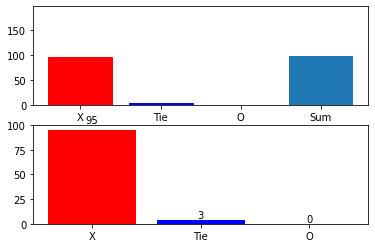

#################


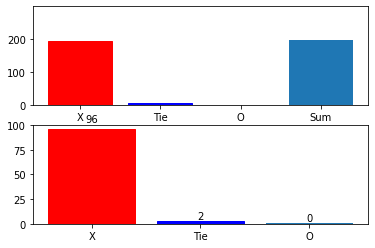

#################


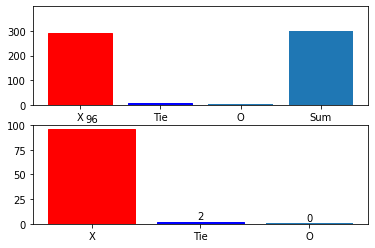

#################


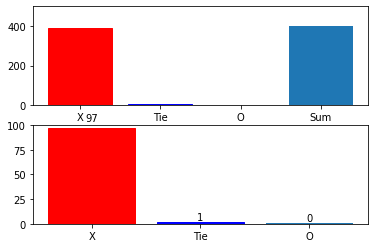

#################


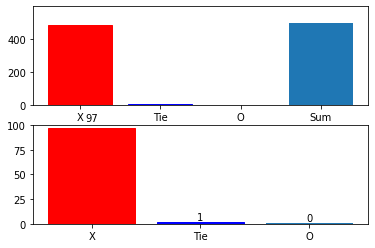

#################


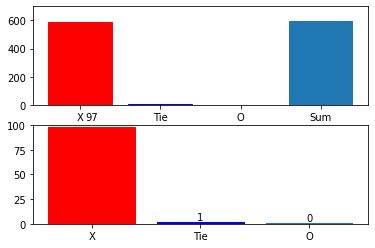

#################


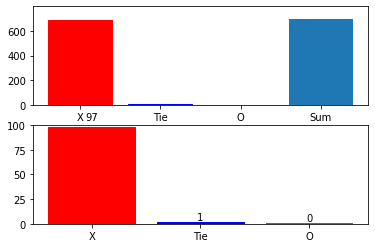

#################


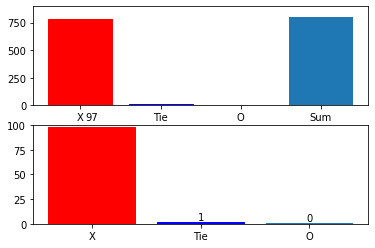

#################


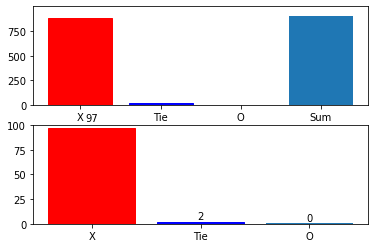

#################


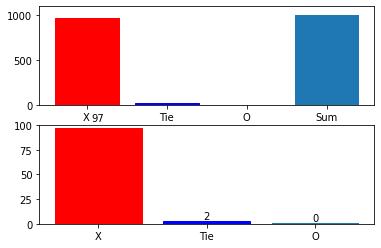

#################
Player      num of wins     prec
--------  -------------  -------
X                   972  97.1029
O                     5   0.4995
Tie                  24   2.3976


In [ ]:
print('QAgent X-1 and QAgent O-0')
game = TicTacToe('QAgent', 'QAgent', 1, 0)
game.play_to_learn(3000)

# Learning phase of 2nd agent

DeepAgent X-1 and DeepAgent O-1
new model
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 18)                180       
                                                                 
 dense_7 (Dense)             (None, 18)                342       
                                                                 
 dense_8 (Dense)             (None, 1)                 19        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________
new model
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 18)                180       
                                                

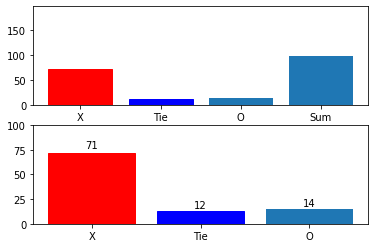

#################


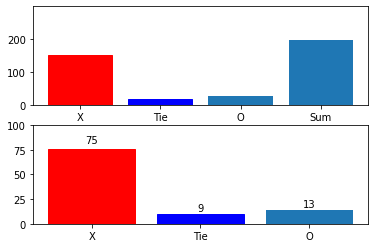

#################


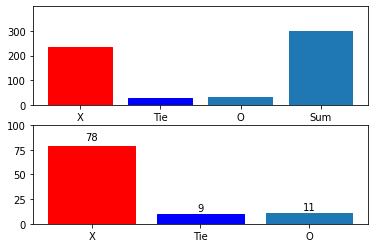

#################


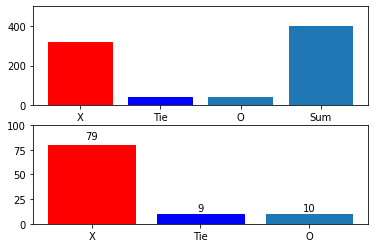

#################


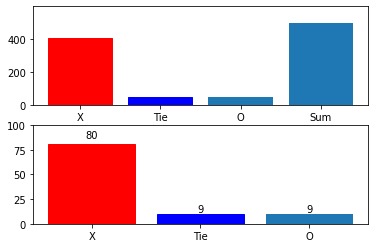

#################
Player      num of wins      prec
--------  -------------  --------
X                   405  80.8383
O                    48   9.58084
Tie                  48   9.58084


In [ ]:
print('DeepAgent X-1 and DeepAgent O-1')
game = TicTacToe('DeepAgent', 'DeepAgent', 1, 0)
game.play_to_learn(500)

In [ ]:

game = TicTacToe('Player', 'DeepAgent', 1, 0.8)
game.play_game()